In [25]:
!rm -rf /content/data_haptic
!unzip -q /content/data_haptic.zip -d /content/data_haptic
!ls /content/data_haptic

data_haptic


## **Task Classification**

In [ ]:
import os, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

warnings.filterwarnings("ignore")

In [ ]:
SEED = 42
np.random.seed(SEED); random.seed(SEED)
BASE_DIR = "/content/data_haptic/data_haptic"
USERS = [f"u{i}" for i in range(1, 9)]
LETTERS = list("abcdefg")
SEQ_LEN = 512

AUG_NOISE_STD = 0.10
AUG_JITTER = 32
AUG_GAIN_RANGE = (0.85, 1.15)
TIME_STRETCH_MAX = 0.1
LABEL_NOISE_LEVEL = 0.1

In [ ]:
def read_force_csv(path):
    df = pd.read_csv(path)
    num = df.select_dtypes(include=[np.number])
    return num.iloc[:, :3].to_numpy(dtype=float)

def load_all_recordings(base_dir):
    rows = []
    for u in USERS:
        for t in LETTERS:
            path = os.path.join(base_dir, u, t, "force.csv")
            if os.path.exists(path):
                rows.append({"user": u, "task": t, "seq": read_force_csv(path)})
    return pd.DataFrame(rows)

def resample_to_len(x, L=SEQ_LEN):
    T = x.shape[0]
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, L)
    return np.stack([np.interp(dst, src, x[:,i]) for i in range(x.shape[1])], axis=1)

def _tiny_time_stretch(x, max_rate=TIME_STRETCH_MAX):
    rate = 1.0 + np.random.uniform(-max_rate, max_rate)
    T = x.shape[0]
    src = np.linspace(0, 1, T)
    dst = np.linspace(0, 1, int(round(T * rate)))
    y = np.stack([np.interp(dst, src, x[:, i]) for i in range(x.shape[1])], axis=1)
    return resample_to_len(y, SEQ_LEN)

def synth_variation(x13):
    y = _tiny_time_stretch(x13)
    s = np.random.randint(-AUG_JITTER, AUG_JITTER + 1)
    if s != 0: y = np.roll(y, shift=s, axis=0)
    gains = np.random.uniform(AUG_GAIN_RANGE[0], AUG_GAIN_RANGE[1], size=(1, y.shape[1]))
    y = y * gains + np.random.normal(0, AUG_NOISE_STD, size=y.shape)
    return y

In [ ]:
# Feature Extraction

def _zcr(x):
    s = np.sign(x)
    return np.mean((s[1:] != s[:-1]).astype(np.float32), axis=0)

def per_timestep_13d(F, fs=250):
    F = np.nan_to_num(F.astype(np.float32))
    F = resample_to_len(F, SEQ_LEN)
    d1 = np.gradient(F, axis=0) * fs
    d2 = np.gradient(d1, axis=0) * fs
    d3 = np.gradient(d2, axis=0) * fs
    norm = lambda x: np.linalg.norm(x, axis=1, keepdims=True)
    return np.concatenate([F, norm(F), d1, norm(d1), d2, norm(d2), norm(d3)], axis=1)

def agg_features_from_seq(x13):
    f = {
        "mean":   np.mean(x13, axis=0),
        "std":    np.std(x13, axis=0) + 1e-8,
        "min":    np.min(x13, axis=0),
        "max":    np.max(x13, axis=0),
        "median": np.median(x13, axis=0),
        "q25":    np.percentile(x13, 25, axis=0),
        "q75":    np.percentile(x13, 75, axis=0),
        "rms":    np.sqrt(np.mean(x13**2, axis=0)),
        "energy": np.mean(x13**2, axis=0),
        "zcr":    _zcr(x13)
    }
    f["iqr"] = f["q75"] - f["q25"]
    keys = ["mean","std","min","max","median","q25","q75","iqr","rms","energy","zcr"]
    return np.concatenate([f[k] for k in keys], axis=0)

In [ ]:
def inject_label_noise(y, noise_level=0.1, num_classes=7):
    y_noisy = y.copy()
    n = int(len(y) * noise_level)
    idx = np.random.choice(len(y), n, replace=False)
    for i in idx:
        y_noisy[i] = np.random.choice([c for c in range(num_classes) if c != y[i]])
    return y_noisy

In [ ]:
def build_task_dataset_for_user(df, user, recs_per_task=15):
    rows = df[df.user == user]
    X_list, y_list, g_list = [], [], []
    rec_id = 0
    for tidx, t in enumerate(LETTERS):
        rt = rows[rows.task == t]
        if len(rt) == 0: continue
        base_seq = per_timestep_13d(rt.iloc[0].seq)
        for r in range(recs_per_task):
            seq = base_seq if r == 0 else synth_variation(base_seq)
            feat = agg_features_from_seq(seq)
            X_list.append(feat)
            y_list.append(tidx)
            g_list.append(rec_id)
            rec_id += 1
    if not X_list:
        return None, None, None
    return np.stack(X_list), np.array(y_list), np.array(g_list)

In [ ]:
# Models

def get_task_model(name):
    if name == "RF":
        return RandomForestClassifier(n_estimators=30, max_depth=4, min_samples_leaf=20, max_features="log2", bootstrap=True, random_state=SEED)
    if name == "LogReg":
        return LogisticRegression(solver="saga", max_iter=3000, multi_class="multinomial", C=1.0, random_state=SEED)
    if name == "SVM":
        return LinearSVC(C=1.0, max_iter=3000, class_weight='balanced', random_state=SEED)
    raise ValueError("Choose from RF, LogReg, SVM")

# Cross-validation per user
def task_gkf_one_user(df, user, model_name="RF", n_splits=5, show_confusion=False):
    Xrec, yrec, groups = build_task_dataset_for_user(df, user)
    assert Xrec is not None, f"No data for {user}"
    gkf = GroupKFold(n_splits=n_splits)
    fold_acc = []
    for fold, (tri, tei) in enumerate(gkf.split(Xrec, yrec, groups), 1):
        Xtr, ytr = Xrec[tri], yrec[tri]
        Xte, yte = Xrec[tei], yrec[tei]
        ytr = inject_label_noise(ytr, noise_level=LABEL_NOISE_LEVEL)
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)
        model = get_task_model(model_name)
        model.fit(Xtr, ytr)
        ypred = model.predict(Xte)
        acc = (ypred == yte).mean()
        fold_acc.append(acc)
        if show_confusion:
            print(f"{user} | {model_name} | Fold {fold} | Acc: {acc:.3f}")
            print(classification_report(yte, ypred, target_names=LETTERS, digits=3))
            cm = confusion_matrix(yte, ypred)
            plt.figure(figsize=(6,5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=LETTERS, yticklabels=LETTERS)
            plt.title(f"{user} — {model_name} — Fold {fold}")
            plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()
    mean_acc = np.mean(fold_acc)
    print(f"{user} | {model_name} | MeanAcc: {mean_acc:.3f}")
    return mean_acc

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def run_letter_recognition_gkf(df, model_names=("RF", "LogReg", "SVM")):
    all_results = []

    for u in tqdm(USERS, desc="Users"):
        for model_name in model_names:
            Xrec, yrec, groups = build_task_dataset_for_user(df, u)
            if Xrec is None:
                continue

            gkf = GroupKFold(n_splits=5)
            all_y_true, all_y_pred = [], []

            for fold, (tri, tei) in enumerate(gkf.split(Xrec, yrec, groups=groups), 1):
                Xtr, ytr = Xrec[tri], yrec[tri]
                Xte, yte = Xrec[tei], yrec[tei]

                ytr = inject_label_noise(ytr, noise_level=LABEL_NOISE_LEVEL)

                scaler = StandardScaler()
                Xtr = scaler.fit_transform(Xtr)
                Xte = scaler.transform(Xte)

                model = get_task_model(model_name)
                model.fit(Xtr, ytr)
                ypred = model.predict(Xte)

                all_y_true.extend(yte)
                all_y_pred.extend(ypred)

            acc = np.mean(np.array(all_y_true) == np.array(all_y_pred))
            prec, rec, f1, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average='macro', zero_division=0)

            all_results.append({
                "User": u,
                "Model": model_name,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1": f1,
                "y_true": all_y_true,
                "y_pred": all_y_pred
            })

    df_results = pd.DataFrame(all_results)

    print("\n Per-user metrics:")
    display(df_results[["User", "Model", "Accuracy", "Precision", "Recall", "F1"]])

    print("\n Average accuracy per model:")
    summary = df_results.groupby("Model")[["Accuracy", "Precision", "Recall", "F1"]].mean().reset_index().sort_values("Accuracy", ascending=False)
    display(summary)

    # Accuracy bar plot
    plt.figure(figsize=(7, 4))
    sns.barplot(data=summary, x="Model", y="Accuracy", palette="Set2")
    plt.title("Model Accuracy Comparison", fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.show()

    # Confusion matrices
    print("\n Confusion Matrices:")
    for model in model_names:
        y_true = np.concatenate(df_results[df_results.Model == model]["y_true"].values)
        y_pred = np.concatenate(df_results[df_results.Model == model]["y_pred"].values)

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LETTERS, yticklabels=LETTERS)
        plt.title(f"Confusion Matrix - {model}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    return df_results, summary

Users:   0%|          | 0/8 [00:00<?, ?it/s]


 Per-user metrics:


,User,Model,Accuracy,Precision,Recall,F1
0,u1,RF,0.923810,0.930672,0.923810,0.922747
1,u1,LogReg,0.942857,0.945238,0.942857,0.942781
2,u1,SVM,0.952381,0.954622,0.952381,0.952648
3,u2,RF,0.800000,0.842641,0.800000,0.794021
4,u2,LogReg,0.980952,0.981548,0.980952,0.980942
5,u2,SVM,0.971429,0.974265,0.971429,0.970590
6,u3,RF,0.819048,0.851517,0.819048,0.812586
7,u3,LogReg,0.961905,0.963690,0.961905,0.961521
8,u3,SVM,0.895238,0.902333,0.895238,0.896230
9,u4,RF,0.838095,0.867036,0.838095,0.832904



 Average accuracy per model:


,Model,Accuracy,Precision,Recall,F1
0,LogReg,0.971429,0.973586,0.971429,0.971384
2,SVM,0.922619,0.930667,0.922619,0.923239
1,RF,0.848810,0.875252,0.848810,0.844379


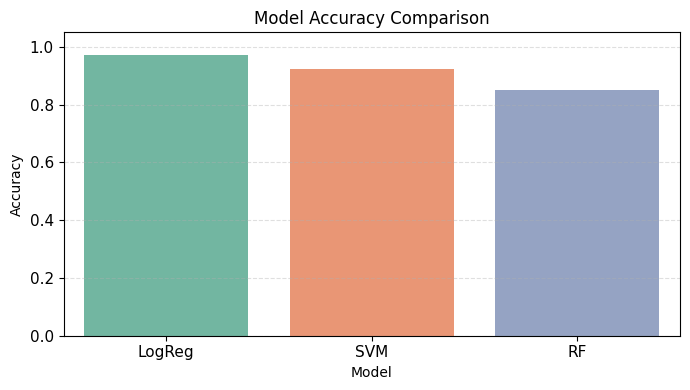


 Confusion Matrices:


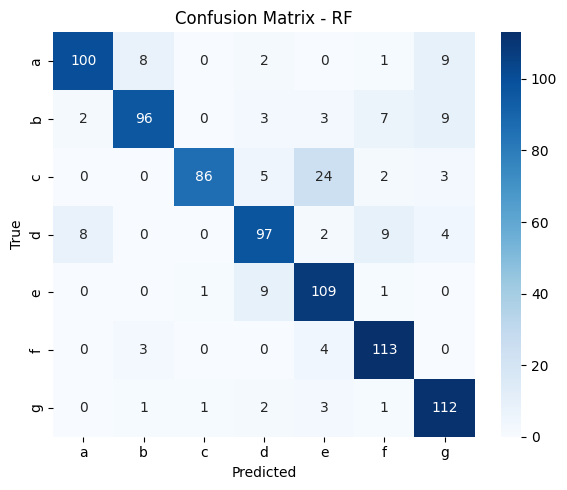

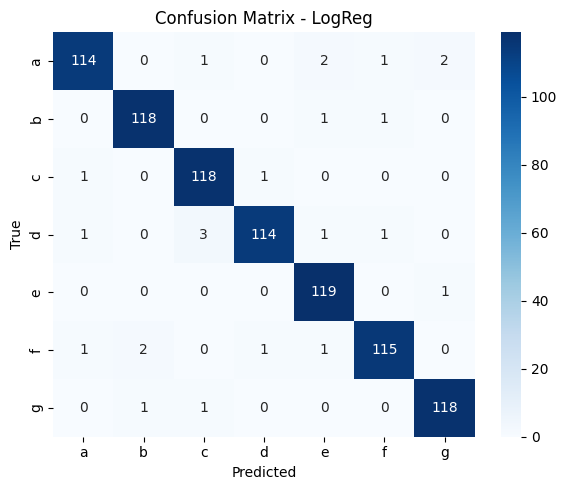

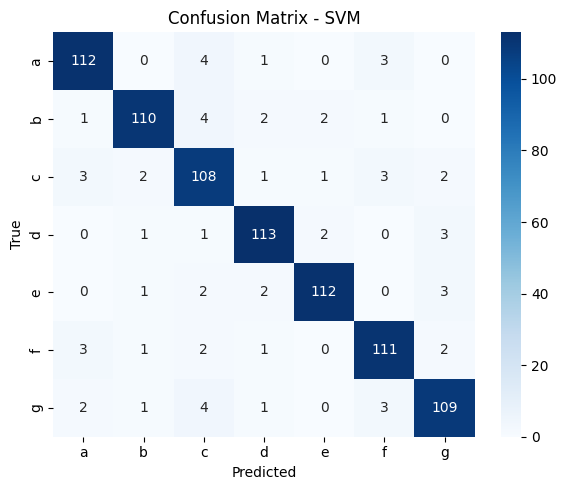

In [ ]:
df = load_all_recordings(BASE_DIR)
results_df, summary_df = run_letter_recognition_gkf(df)

# **User Identification**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [ ]:
USER_MODELS = ("RF", "LogReg", "SVM")
LABEL_NOISE_LEVEL = 0.1
BASE_DIR = "/content/data_haptic/data_haptic"
USERS = [f"u{i}" for i in range(1, 9)]
LETTERS = list("abcdefg")

In [ ]:
def get_user_model(name):
    if name == "RF":
        return RandomForestClassifier(n_estimators=10, max_depth=3, min_samples_leaf=8, max_features="sqrt", random_state=SEED)
    if name == "LogReg":
        return LogisticRegression(solver="saga", max_iter=3000, multi_class="multinomial", C=1.0, random_state=SEED)
    if name == "SVM":
        return LinearSVC(C=1.0, max_iter=3000, class_weight='balanced', random_state=SEED)
    raise ValueError("Choose from RF, LogReg, SVM")

def read_force_csv(path):
    df = pd.read_csv(path)
    num = df.select_dtypes(include=[np.number])
    return num.iloc[:, :3].to_numpy(dtype=float)

def load_all_recordings(base_dir):
    rows = []
    for user in os.listdir(base_dir):
        user_path = os.path.join(base_dir, user)
        if not os.path.isdir(user_path):
            continue
        for task in os.listdir(user_path):
            task_path = os.path.join(user_path, task)
            file_path = os.path.join(task_path, "force.csv")
            if os.path.isfile(file_path):
                seq = read_force_csv(file_path)
                rows.append({
                    "user": user,        # u1 to u8
                    "task": task,        # a to g
                    "seq": seq
                })
    df = pd.DataFrame(rows)
    print(f"Loaded {len(df)} recordings")
    print("Users:", df["user"].value_counts().sort_index().to_dict())
    return df

In [ ]:
def build_user_dataset_for_task(df, task, recs_per_user=30):
    rows = df[df.task == task]
    X_list, y_list, g_list = [], [], []
    rec_id = 0
    for uid, u in enumerate(USERS):
        ru = rows[rows.user == u]
        if len(ru) == 0: continue
        base_seq = per_timestep_13d(ru.iloc[0].seq)
        for r in range(recs_per_user):
            seq = base_seq if r == 0 else synth_variation(base_seq)
            feat = agg_features_from_seq(seq)
            X_list.append(feat)
            y_list.append(uid)
            g_list.append(rec_id)
            rec_id += 1
    if not X_list:
        return None, None, None
    return np.stack(X_list), np.array(y_list), np.array(g_list)

In [ ]:
# Noise

def inject_label_noise(y, noise_level=0.1):
    y = y.copy()
    n = int(len(y) * noise_level)
    idx = np.random.choice(len(y), n, replace=False)
    for i in idx:
        choices = list(set(range(len(USERS))) - {y[i]})
        y[i] = np.random.choice(choices)
    return y

In [ ]:
def run_user_identification(df, model_names=USER_MODELS):
    all_results = []

    for task in tqdm(LETTERS, desc="Tasks"):
        for model_name in model_names:
            Xrec, yrec, groups = build_user_dataset_for_task(df, task)
            if Xrec is None: continue

            gkf = GroupKFold(n_splits=5)
            all_y_true, all_y_pred = [], []

            for fold, (tri, tei) in enumerate(gkf.split(Xrec, yrec, groups=groups), 1):
                Xtr, ytr = Xrec[tri], yrec[tri]
                Xte, yte = Xrec[tei], yrec[tei]

                ytr = inject_label_noise(ytr, LABEL_NOISE_LEVEL)

                scaler = StandardScaler()
                Xtr = scaler.fit_transform(Xtr)
                Xte = scaler.transform(Xte)

                model = get_user_model(model_name)
                model.fit(Xtr, ytr)
                ypred = model.predict(Xte)

                all_y_true.extend(yte)
                all_y_pred.extend(ypred)

            acc = np.mean(np.array(all_y_true) == np.array(all_y_pred))
            prec, rec, f1, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average='macro', zero_division=0)

            all_results.append({
                "Task": task,
                "Model": model_name,
                "Accuracy": acc,
                "Precision": prec,
                "Recall": rec,
                "F1": f1,
                "y_true": all_y_true,
                "y_pred": all_y_pred
            })

    df_results = pd.DataFrame(all_results)

    # Display summary
    print(" Per-task User Identification Results:")
    display(df_results[["Task", "Model", "Accuracy", "Precision", "Recall", "F1"]])

    print("\n Average Accuracy per Model:")
    summary = df_results.groupby("Model")[["Accuracy", "Precision", "Recall", "F1"]].mean().reset_index()
    display(summary)

    # Plot accuracy
    plt.figure(figsize=(8, 4))
    sns.barplot(data=summary, x="Model", y="Accuracy", palette="Set2")
    plt.title("User Identification Accuracy by Model")
    plt.ylim(0, 1.05)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    # Confusion matrices
    print("\n Confusion Matrices per Model:")
    for model in model_names:
        y_true = np.concatenate(df_results[df_results.Model == model]["y_true"].values)
        y_pred = np.concatenate(df_results[df_results.Model == model]["y_pred"].values)
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=USERS, yticklabels=USERS)
        plt.title(f"Confusion Matrix — {model}")
        plt.xlabel("Predicted"); plt.ylabel("True")
        plt.tight_layout()
        plt.show()

    return df_results, summary

In [ ]:
BASE_DIR = "data_haptic/data_haptic"
df = load_all_recordings(BASE_DIR)

Loaded 56 recordings
Users: {'u1': 7, 'u2': 7, 'u3': 7, 'u4': 7, 'u5': 7, 'u6': 7, 'u7': 7, 'u8': 7}


In [ ]:
from tqdm.auto import tqdm

Tasks:   0%|          | 0/7 [00:00<?, ?it/s]

 Per-task User Identification Results:


,Task,Model,Accuracy,Precision,Recall,F1
0,a,RF,0.962500,0.967803,0.962500,0.961864
1,a,LogReg,0.970833,0.971201,0.970833,0.970755
2,a,SVM,0.937500,0.939883,0.937500,0.937027
3,b,RF,0.995833,0.995968,0.995833,0.995832
4,b,LogReg,0.970833,0.972104,0.970833,0.970951
5,b,SVM,0.937500,0.940820,0.937500,0.937901
6,c,RF,0.991667,0.991935,0.991667,0.991664
7,c,LogReg,0.975000,0.975672,0.975000,0.975060
8,c,SVM,0.916667,0.920506,0.916667,0.915961
9,d,RF,0.995833,0.995968,0.995833,0.995832



 Average Accuracy per Model:


,Model,Accuracy,Precision,Recall,F1
0,LogReg,0.975000,0.975910,0.975000,0.975031
1,RF,0.985119,0.986351,0.985119,0.985039
2,SVM,0.928571,0.930877,0.928571,0.928358


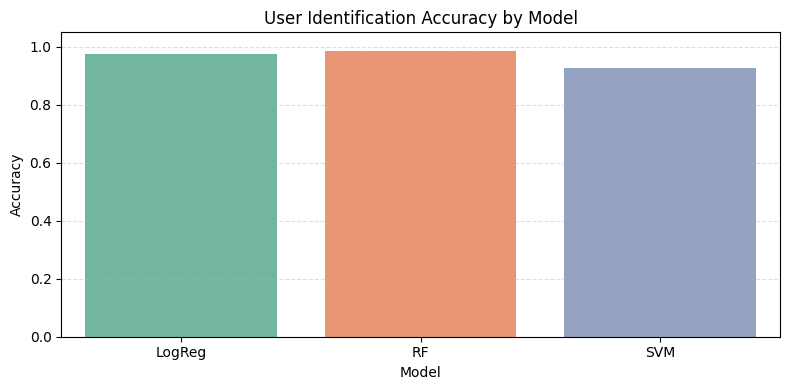


 Confusion Matrices per Model:


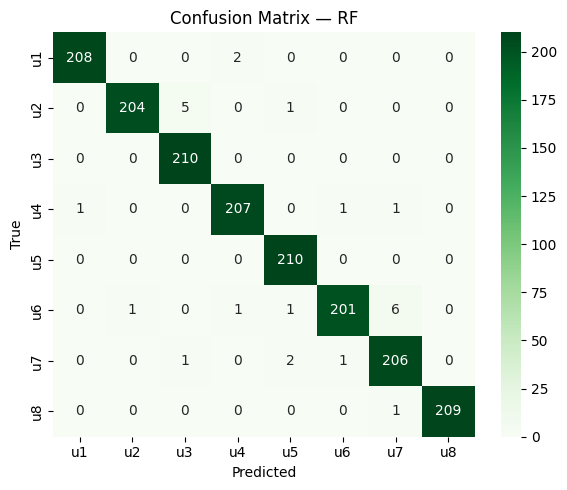

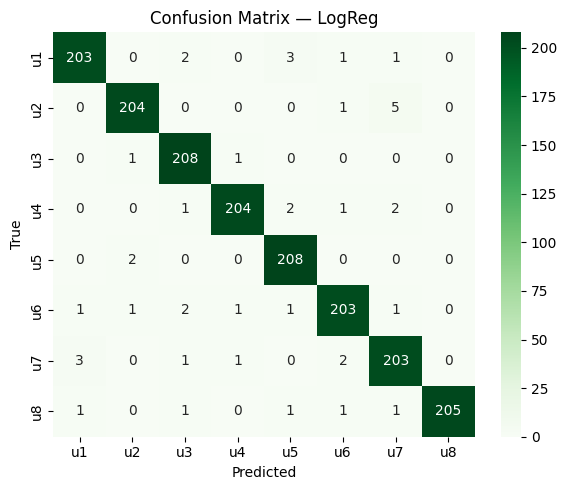

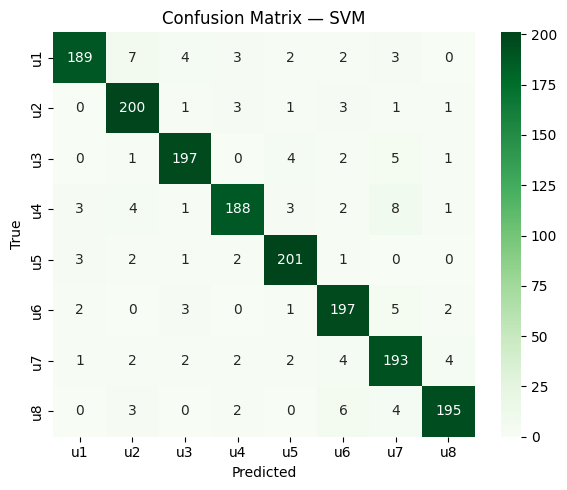

In [ ]:
results_df, summary_df = run_user_identification(df)

# **User Classification**

In [ ]:
!pip install --upgrade xgboost

In [1]:
!pip -q install lightgbm==4.3.0 imbalanced-learn==0.12.3

In [2]:
import os, glob, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy import signal, stats
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, average_precision_score)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import BorderlineSMOTE, SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

plt.rcParams["figure.dpi"] = 140

In [3]:
ROOT = "/content/data_haptic/data_haptic"
tasks = list('abcdefg')
users = sorted([d for d in os.listdir(ROOT) if d.startswith('u')])
print("Users:", users, "\nTasks:", tasks)

Users: ['u1', 'u2', 'u3', 'u4', 'u5', 'u6', 'u7', 'u8'] 
Tasks: ['a', 'b', 'c', 'd', 'e', 'f', 'g']


In [4]:
# Data Loading

def load_force_csv(path):
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}
    guess = list(df.columns[-3:]) if len(df.columns) >= 3 else list(df.columns)

    fx = cols.get('fx') or cols.get('force_x') or cols.get('forcex') or (guess[0] if guess else None)
    fy = cols.get('fy') or cols.get('force_y') or cols.get('forcey') or (guess[1] if len(guess)>1 else None)
    fz = cols.get('fz') or cols.get('force_z') or cols.get('forcez') or (guess[2] if len(guess)>2 else None)
    t  = cols.get('time') or cols.get('timestamp')

    out = pd.DataFrame({
        'Fx': pd.to_numeric(df[fx], errors='coerce'),
        'Fy': pd.to_numeric(df[fy], errors='coerce'),
        'Fz': pd.to_numeric(df[fz], errors='coerce'),
    })
    if t is not None:
        out['time'] = pd.to_numeric(df[t], errors='coerce')
    out = out.dropna()
    return out.reset_index(drop=True)

In [5]:
# Feature Engineering

def _safe(v, default=0.0):
    try:
        v = float(v)
        return v if np.isfinite(v) else default
    except Exception:
        return default

def safe_grad(x, dt): return np.gradient(x, dt)

def basic_stats(x, prefix):
    feats = {}
    x = np.asarray(x, dtype=float)
    feats[f'{prefix}_mean']   = _safe(np.mean(x))
    feats[f'{prefix}_std']    = _safe(np.std(x))
    feats[f'{prefix}_min']    = _safe(np.min(x))
    feats[f'{prefix}_max']    = _safe(np.max(x))
    feats[f'{prefix}_median'] = _safe(np.median(x))
    feats[f'{prefix}_iqr']    = _safe(stats.iqr(x)) if len(x)>1 else 0.0
    feats[f'{prefix}_rms']    = _safe(np.sqrt(np.mean(x**2)))
    for name, func in [('skew', stats.skew), ('kurt', stats.kurtosis)]:
        try: feats[f'{prefix}_{name}'] = _safe(func(x, bias=False))
        except: feats[f'{prefix}_{name}'] = 0.0
    feats[f'{prefix}_zcr']    = _safe(((x[:-1]*x[1:])<0).mean()) if len(x)>1 else 0.0
    feats[f'{prefix}_ptp']    = _safe(np.ptp(x))
    feats[f'{prefix}_energy'] = _safe(np.sum(x**2))
    px = np.abs(x).astype(float); s = px.sum()
    feats[f'{prefix}_log_entropy'] = 0.0 if s<=0 or not np.isfinite(s) else _safe(-np.sum((px/s)*np.log(px/s + 1e-12)))
    return feats

def spectral_feats(x, fs, prefix):
    nper = min(1024, len(x)) if len(x) > 8 else max(8, len(x))
    f, Pxx = signal.welch(x, fs=fs, nperseg=nper)
    Pxx = np.nan_to_num(Pxx, nan=0.0, posinf=0.0, neginf=0.0) + 1e-12
    P = Pxx/Pxx.sum()
    return {f'{prefix}_spec_centroid': _safe(np.sum(f*P)),
            f'{prefix}_spec_entropy':  _safe(-np.sum(P*np.log(P)))}

def pair_corr(a,b,prefix):
    if len(a)<2 or len(b)<2: return {f'{prefix}_pearson': 0.0}
    return {f'{prefix}_pearson': _safe(np.corrcoef(a,b)[0,1])}

def extract_features_from_signal(df, default_fs=250.0):
    if 'time' in df.columns and len(df['time'])>1:
        dt = np.median(np.diff(df['time'].values)); fs = 1.0/max(dt,1e-6)
    else:
        fs = default_fs; dt = 1.0/fs

    Fx, Fy, Fz = df['Fx'].values, df['Fy'].values, df['Fz'].values
    Vx, Vy, Vz = safe_grad(Fx, dt), safe_grad(Fy, dt), safe_grad(Fz, dt)
    Ax, Ay, Az = safe_grad(Vx, dt), safe_grad(Vy, dt), safe_grad(Vz, dt)
    Jx, Jy, Jz = safe_grad(Ax, dt), safe_grad(Ay, dt), safe_grad(Az, dt)

    Fn = np.sqrt(Fx**2 + Fy**2 + Fz**2)
    Vn = np.sqrt(Vx**2 + Vy**2 + Vz**2)
    An = np.sqrt(Ax**2 + Ay**2 + Az**2)
    Jn = np.sqrt(Jx**2 + Jy**2 + Jz**2)

    feats = {'length': len(df), 'fs': fs}
    for arr,name in [(Fx,'Fx'),(Fy,'Fy'),(Fz,'Fz'),
                     (Vx,'Vx'),(Vy,'Vy'),(Vz,'Vz'),
                     (Ax,'Ax'),(Ay,'Ay'),(Az,'Az'),
                     (Jx,'Jx'),(Jy,'Jy'),(Jz,'Jz'),
                     (Fn,'Fn'),(Vn,'Vn'),(An,'An'),(Jn,'Jn')]:
        feats.update(basic_stats(arr, name))
    feats.update(pair_corr(Fx,Fy,'corr_FxFy')); feats.update(pair_corr(Fx,Fz,'corr_FxFz')); feats.update(pair_corr(Fy,Fz,'corr_FyFz'))
    for arr,name in [(Fx,'Fx'),(Fy,'Fy'),(Fz,'Fz'),(Fn,'Fn')]:
        feats.update(spectral_feats(arr, fs, name))
    return feats

In [6]:
def build_dataset(root=ROOT, use_only='force.csv', tasks=list('abcdefg')):
    rows = []
    for u in sorted([d for d in os.listdir(root) if d.startswith('u')]):
        upath = os.path.join(root, u)
        for t in tasks:
            tpath = os.path.join(upath, t)
            if not os.path.isdir(tpath): continue
            fpath = os.path.join(tpath, use_only)
            if not os.path.exists(fpath):
                cand = glob.glob(os.path.join(tpath, "*force*.csv"))
                if cand: fpath = cand[0]
                else: continue
            try:
                df = load_force_csv(fpath)
                feats = extract_features_from_signal(df)
                feats['user'] = u; feats['task'] = t; feats['path'] = fpath
                rows.append(feats)
            except Exception as e:
                print("Failed:", fpath, e)
    X = pd.DataFrame(rows)
    X.replace([np.inf,-np.inf], np.nan, inplace=True)
    X.fillna(0.0, inplace=True)
    return X

features_df = build_dataset(ROOT)
display(features_df.head())
print(features_df.shape, "samples")

,length,fs,Fx_mean,Fx_std,Fx_min,Fx_max,Fx_median,Fx_iqr,Fx_rms,Fx_skew,...,Fx_spec_entropy,Fy_spec_centroid,Fy_spec_entropy,Fz_spec_centroid,Fz_spec_entropy,Fn_spec_centroid,Fn_spec_entropy,user,task,path
0,692781,250.0,0.534260,1.295449,-15.562745,551.092591,0.028806,0.781060,1.401293,142.295252,...,5.799708,38.497828,5.370301,33.522251,5.007270,2.842061,2.037824,u1,a,/content/data_haptic/data_haptic/u1/a/force.csv
1,566085,250.0,0.548631,1.981058,-28.739772,1211.224566,0.024369,1.060357,2.055623,425.604150,...,6.088086,36.729936,5.247873,27.758607,4.412944,5.432854,2.324871,u1,b,/content/data_haptic/data_haptic/u1/b/force.csv
2,216426,250.0,0.445932,1.924668,-14.726707,579.528444,0.029387,0.669033,1.975652,166.637716,...,6.088141,39.340082,5.376635,39.142044,5.274553,3.160262,2.136385,u1,c,/content/data_haptic/data_haptic/u1/c/force.csv
3,337697,250.0,0.631612,2.817335,-16.247111,1167.255269,0.025716,1.047435,2.887267,260.674871,...,6.173023,38.663703,5.618396,31.015676,4.684393,8.655381,2.701824,u1,d,/content/data_haptic/data_haptic/u1/d/force.csv
4,426218,250.0,1.020381,1.498357,-11.418879,435.563058,0.030673,2.842356,1.812802,57.847262,...,5.905098,39.394726,5.569893,46.786464,5.979647,8.550894,2.670842,u1,e,/content/data_haptic/data_haptic/u1/e/force.csv


(56, 224) samples


In [7]:
# Models

def make_models():
    lgbm = LGBMClassifier(
        n_estimators=600, learning_rate=0.05, num_leaves=15,
        subsample=0.9, colsample_bytree=0.9,
        min_child_samples=1, min_data_in_leaf=1, objective='binary',
        force_col_wise=True, random_state=42, n_jobs=-1
    )
    return {
        "LightGBM": lgbm,
        "HistGB": HistGradientBoostingClassifier(max_iter=400, learning_rate=0.06, random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=500, class_weight="balanced_subsample", n_jobs=-1, random_state=42),
        "ExtraTrees": ExtraTreesClassifier(n_estimators=600, class_weight="balanced_subsample", n_jobs=-1, random_state=42),
        "LinearSVM": CalibratedClassifierCV(LinearSVC(C=1.0, class_weight='balanced', random_state=42), method='sigmoid'),
        "LogReg": LogisticRegression(max_iter=4000, class_weight='balanced', n_jobs=-1),
    }

In [8]:
# Evaluation (Valid vs Invalid)

from collections import defaultdict
import numpy as np
import pandas as pd

feature_cols = [c for c in features_df.columns if c not in ['user','task','path']]
users_list   = sorted(features_df['user'].unique())

def _best_f1_threshold(y_true, y_score):
    p, r, t = precision_recall_curve(y_true, y_score)
    if len(t) == 0:
        return 0.5
    f1 = 2*p*r / (p + r + 1e-12)
    return float(t[np.argmax(f1[:-1])])

def _make_sampler_for(y_vec):
    pos = int(np.sum(y_vec))
    if pos <= 2:
        return RandomOverSampler(random_state=42)
    elif pos <= 5:
        return SMOTE(k_neighbors=max(1, pos-1), random_state=42)
    else:
        return BorderlineSMOTE(k_neighbors=min(5, pos-1), random_state=42)

def evaluate_spoof_detection_balanced(features_df, feature_cols, inner_splits=3):
    X_all  = features_df[feature_cols].values
    groups = features_df['task'].values
    users  = features_df['user'].values
    models = make_models()

    results = defaultdict(list)
    cms_by_model = defaultdict(lambda: np.zeros((2,2), dtype=int))
    roc_store = defaultdict(lambda: {"y_true": [], "y_score": []})
    pr_store  = defaultdict(lambda: {"y_true": [], "y_score": []})

    for target_user in users_list:
        y = (users == target_user).astype(int)

        for name, model in models.items():
            outer_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

            y_true_all, y_pred_all, y_score_all = [], [], []

            for tr, te in outer_cv.split(X_all, y, groups):
                X_tr, y_tr = X_all[tr], y[tr]
                X_te, y_te = X_all[te], y[te]

                inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)
                inner_y, inner_score = [], []

                for itr, ival in inner_cv.split(X_tr, y_tr):
                    sampler = _make_sampler_for(y_tr[itr])
                    steps = [
                        ('imputer', SimpleImputer(strategy='median')),
                        ('var', VarianceThreshold(1e-8)),
                        ('sampler', sampler),
                    ]
                    if name in ["LinearSVM","LogReg"]:
                        steps += [('scaler', StandardScaler())]
                    steps += [('clf', models[name])]
                    inner_pipe = ImbPipeline(steps)

                    inner_pipe.fit(X_tr[itr], y_tr[itr])
                    if hasattr(inner_pipe.named_steps['clf'], "predict_proba"):
                        s = inner_pipe.predict_proba(X_tr[ival])[:,1]
                    else:
                        s = inner_pipe.decision_function(X_tr[ival])
                    inner_y.extend(y_tr[ival]); inner_score.extend(s)

                thr = _best_f1_threshold(np.array(inner_y), np.array(inner_score))

                sampler = _make_sampler_for(y_tr)
                steps = [
                    ('imputer', SimpleImputer(strategy='median')),
                    ('var', VarianceThreshold(1e-8)),
                    ('sampler', sampler),
                ]
                if name in ["LinearSVM","LogReg"]:
                    steps += [('scaler', StandardScaler())]
                steps += [('clf', models[name])]
                pipe = ImbPipeline(steps)

                pipe.fit(X_tr, y_tr)
                if hasattr(pipe.named_steps['clf'], "predict_proba"):
                    scores = pipe.predict_proba(X_te)[:,1]
                else:
                    scores = pipe.decision_function(X_te)
                preds = (scores >= thr).astype(int)

                y_true_all.extend(y_te); y_pred_all.extend(preds); y_score_all.extend(scores)

            y_true_all = np.array(y_true_all); y_pred_all = np.array(y_pred_all); y_score_all = np.array(y_score_all)

            acc  = accuracy_score(y_true_all, y_pred_all)
            prec = precision_score(y_true_all, y_pred_all, zero_division=0)
            rec  = recall_score(y_true_all, y_pred_all, zero_division=0)
            f1   = f1_score(y_true_all, y_pred_all, zero_division=0)
            auc  = roc_auc_score(y_true_all, y_score_all)
            cm   = confusion_matrix(y_true_all, y_pred_all, labels=[0,1])

            cms_by_model[name] += cm
            roc_store[name]["y_true"].extend(list(y_true_all))
            roc_store[name]["y_score"].extend(list(y_score_all))
            pr_store[name]["y_true"].extend(list(y_true_all))
            pr_store[name]["y_score"].extend(list(y_score_all))

            results['model'].append(name)
            results['user'].append(target_user)
            results['accuracy'].append(acc)
            results['precision'].append(prec)
            results['recall'].append(rec)
            results['f1'].append(f1)
            results['auc'].append(auc)

    results_df = pd.DataFrame(results)
    avg_df = (results_df.groupby('model')[['accuracy','precision','recall','f1','auc']]
              .mean().sort_values('accuracy', ascending=False))
    return results_df, avg_df, cms_by_model, roc_store, pr_store

results_df, avg_df, cms_by_model, roc_store, pr_store = evaluate_spoof_detection_balanced(features_df, feature_cols)
display(avg_df)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive g

,accuracy,precision,recall,f1,auc
model,,,,,
HistGB,0.743304,0.305781,0.482143,0.356227,0.711006
LightGBM,0.707589,0.285922,0.535714,0.357550,0.741254
RandomForest,0.662946,0.277381,0.571429,0.343610,0.726494
ExtraTrees,0.629464,0.227619,0.571429,0.309717,0.712099
LinearSVM,0.587054,0.207696,0.607143,0.290801,0.671283
LogReg,0.582589,0.218094,0.553571,0.281587,0.652332


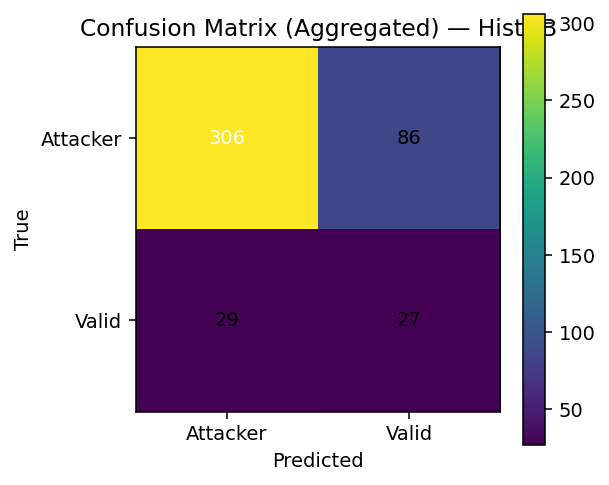

In [9]:
# Confusion Matrix

best_model = avg_df.index[0]
cm = cms_by_model[best_model]

fig, ax = plt.subplots(figsize=(4.2,4))
im = ax.imshow(cm, cmap='viridis')
ax.set_title(f'Confusion Matrix (Aggregated) — {best_model}')
ax.set_xticks([0,1]); ax.set_xticklabels(['Attacker','Valid'])
ax.set_yticks([0,1]); ax.set_yticklabels(['Attacker','Valid'])
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i,j] > cm.max()/2 else "black")
plt.xlabel('Predicted'); plt.ylabel('True'); plt.colorbar(im); plt.show()

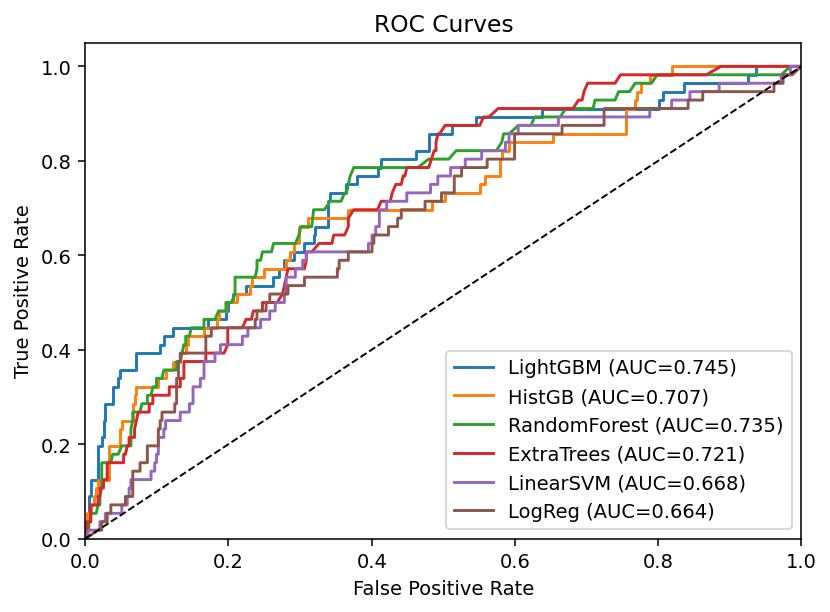

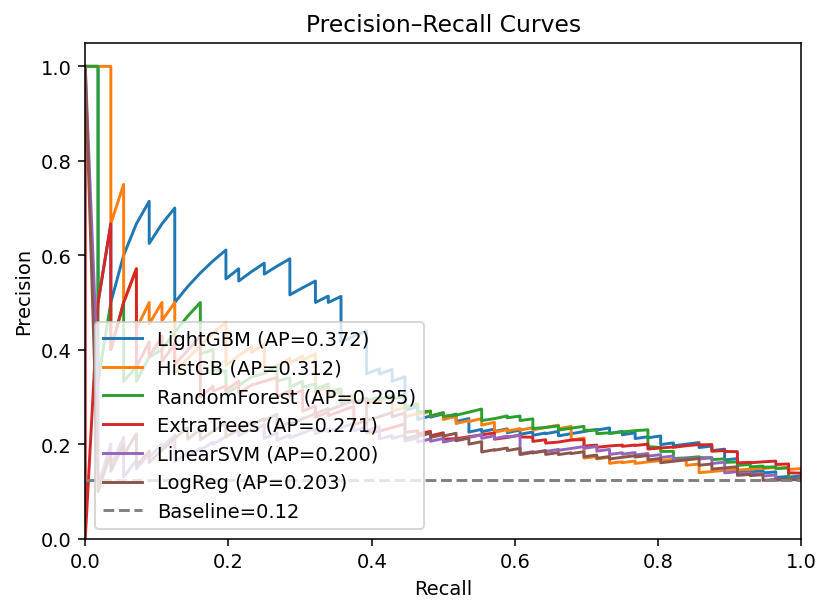

In [10]:
# ROC curve

plt.figure(figsize=(6.6,4.6))
for name, store in roc_store.items():
    y_true = np.array(store["y_true"]); y_score = np.array(store["y_score"])
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curves'); plt.legend(loc='lower right')
plt.show()

plt.figure(figsize=(6.6,4.6))
for name, store in pr_store.items():
    y_true = np.array(store["y_true"]); y_score = np.array(store["y_score"])
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.plot(rec, prec, label=f'{name} (AP={ap:.3f})')

pos_rate = (y_true.mean() if len(pr_store)>0 else 0.5)
plt.hlines(pos_rate, 0, 1, linestyles='dashed', colors='gray', label=f'Baseline={pos_rate:.2f}')
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall Curves'); plt.legend(loc='lower left')
plt.show()

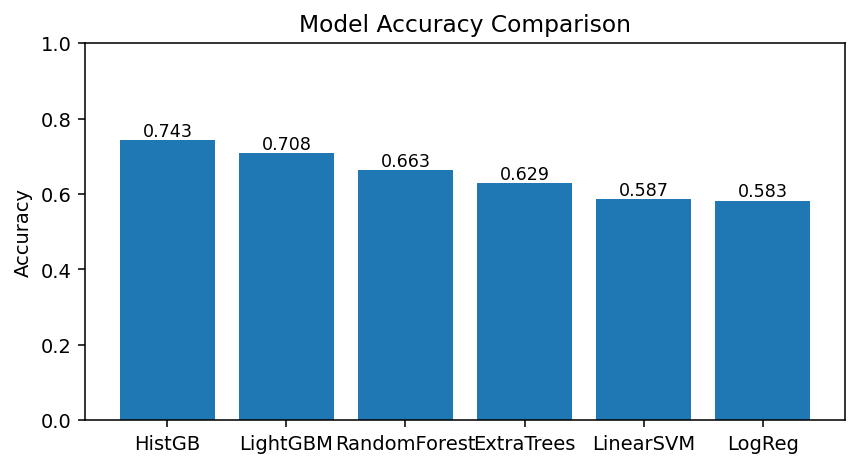

In [11]:
# Bar chart

bar = avg_df.reset_index()[['model','accuracy']].sort_values('accuracy', ascending=False)
plt.figure(figsize=(7,3.5))
plt.bar(bar['model'], bar['accuracy'])
plt.ylim(0,1.0)
plt.ylabel('Accuracy'); plt.title('Model Accuracy Comparison')
for i,v in enumerate(bar['accuracy']):
    plt.text(i, v+0.01, f'{v:.3f}', ha='center', fontsize=9)
plt.show()

In [12]:
# Per user accuracy table

per_user = (results_df.pivot_table(index='user', columns='model', values='accuracy', aggfunc='mean')
            .reindex(sorted(results_df['user'].unique())))
per_user

model,ExtraTrees,HistGB,LightGBM,LinearSVM,LogReg,RandomForest
user,,,,,,
u1,0.785714,0.928571,0.928571,0.821429,0.875000,0.892857
u2,0.785714,0.660714,0.625000,0.553571,0.517857,0.714286
u3,0.785714,0.875000,0.750000,0.803571,0.839286,0.821429
u4,0.232143,0.696429,0.267857,0.303571,0.321429,0.267857
u5,0.642857,0.821429,0.839286,0.303571,0.375000,0.839286
u6,0.714286,0.767857,0.785714,0.589286,0.553571,0.642857
u7,0.803571,0.750000,0.803571,0.750000,0.553571,0.785714
u8,0.285714,0.446429,0.660714,0.571429,0.625000,0.339286
